# Faulty LED seven-edge digit recognition

#### Josep Fortiana 2019-11-26

## Original problem

The problem involves representations of digits by seven LED lights which are selectively lit to form each digit. It is described in the book: Leo Breiman, Jerome Friedman, R.A. Olshen and Charles J. Stone (1984) _Classification and Regression Trees_ (BFOS), p. 43-49.

`Digits.plot.r` contains auxiliary functions for visualizing them.

In [1]:
source("Digits.plot.r")

The figure below shows the numbering of the seven edges used to form the digits

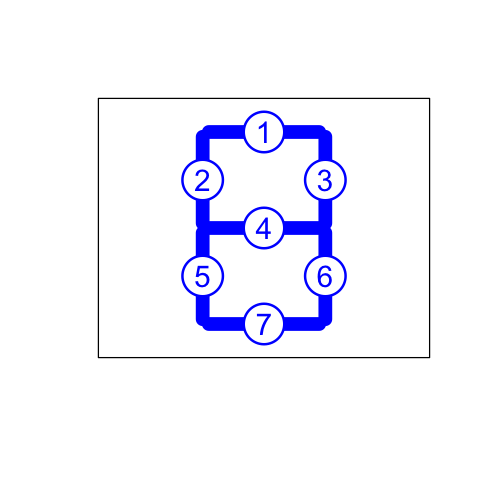

In [2]:
options(repr.plot.width=4,repr.plot.height=4)
plot.digits.matrix.with.segment.indexes(cex=0.5)

Here we see the ten digits, represented by the seven edges.

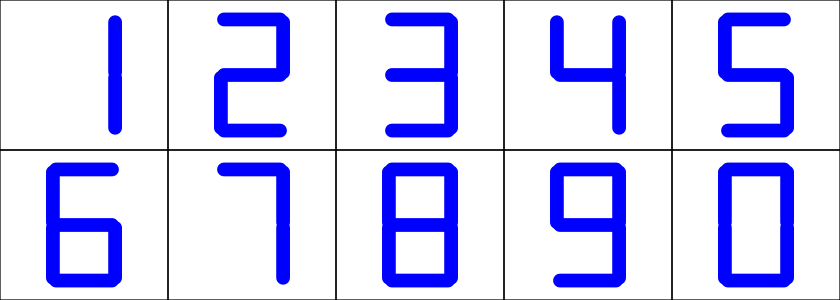

In [3]:
options(repr.plot.width=7.0,repr.plot.height=2.5)
show.all.digits()

The file `digits.csv` contains $500$ sets (rows), each with seven ones and zeros, representing `ON`/`OFF` status for each of the seven edges, numbered as above, plus a label, the intended digit. Most rows, however, contain faulty edges, set `ON` when they should be `OFF` and vice-versa. For instance, the following picture shows a faulty '5' where the sixth edge failed to light on.

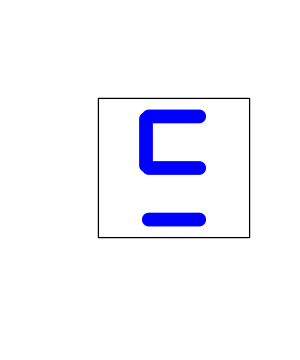

In [4]:
options(repr.plot.width=2.5,repr.plot.height=3.0)
v<-as.logical(c(1,1,0,1,0,0,1))
plot.faulty.digit(v)

Each row in `digits.csv` contains an additional variable, `DIGIT`, with the name of the intended digit.

In [5]:
digits.data<-read.csv("digits.csv")
str(digits.data)

'data.frame':	500 obs. of  8 variables:
 $ digit: Factor w/ 10 levels "eight","five",..: 6 5 3 9 1 5 2 7 9 1 ...
 $ x1   : int  1 0 0 1 0 0 1 1 1 1 ...
 $ x2   : int  0 0 1 1 1 0 1 0 0 1 ...
 $ x3   : int  1 1 1 1 1 1 0 0 1 1 ...
 $ x4   : int  0 0 1 1 1 0 1 1 1 1 ...
 $ x5   : int  0 0 0 1 1 0 0 1 1 0 ...
 $ x6   : int  1 1 1 0 1 1 1 1 0 1 ...
 $ x7   : int  0 0 0 0 1 0 1 1 1 1 ...


In [6]:
levels(digits.data$digit)

[1] "eight" "five"  "four"  "nine"  "one"   "seven" "six"   "three" "two"  
[10] "zero"

Better with shorter (and equal length) names for levels

In [7]:
#install.packages("dplyr",dependencies=TRUE,repos="https://cloud.r-project.org")
require(dplyr)

Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [8]:
digits.data$digit<-recode(digits.data$digit,"one"="1","two"="2","three"="3","four"="4","five"="5","six"="6","seven"="7",
                          "eight"="8","nine"="9","zero"="0")

In [9]:
str(digits.data)

'data.frame':	500 obs. of  8 variables:
 $ digit: Factor w/ 10 levels "8","5","4","9",..: 6 5 3 9 1 5 2 7 9 1 ...
 $ x1   : int  1 0 0 1 0 0 1 1 1 1 ...
 $ x2   : int  0 0 1 1 1 0 1 0 0 1 ...
 $ x3   : int  1 1 1 1 1 1 0 0 1 1 ...
 $ x4   : int  0 0 1 1 1 0 1 1 1 1 ...
 $ x5   : int  0 0 0 1 1 0 0 1 1 0 ...
 $ x6   : int  1 1 1 0 1 1 1 1 0 1 ...
 $ x7   : int  0 0 0 0 1 0 1 1 1 1 ...


In [10]:
table(digits.data$digit)


 8  5  4  9  1  7  6  3  2  0 
58 54 52 55 43 48 50 55 43 42 

## Generating more data

Possibly the `digits.csv` dataset is extracted from the collection of datasets in the _Splus_ program. In the BFOS book they mention an (unpublished, I believe) training dataset with $200$ observations and a test sample of $5000$. The generator program by David W. Aha, in C, can be found at the [UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/LED+Display+Domain).

A better alternative is the `rdigitsBFOS()` function from the `gencve` package, which generates digits with a given flipping probability `alpha` (that is, the probability of one of the seven LEDs changing its correct status to the opposite one). As a bonus the function computes the Bayes optimal missclassification rate, which can be used to have an objective lower
bound for the quality of any classification method.

In [11]:
#install.packages("gencve",dependencies=TRUE,repos="https://cloud.r-project.org")
require(gencve)

Loading required package: gencve


In [12]:
str(digits.data)

'data.frame':	500 obs. of  8 variables:
 $ digit: Factor w/ 10 levels "8","5","4","9",..: 6 5 3 9 1 5 2 7 9 1 ...
 $ x1   : int  1 0 0 1 0 0 1 1 1 1 ...
 $ x2   : int  0 0 1 1 1 0 1 0 0 1 ...
 $ x3   : int  1 1 1 1 1 1 0 0 1 1 ...
 $ x4   : int  0 0 1 1 1 0 1 1 1 1 ...
 $ x5   : int  0 0 0 1 1 0 0 1 1 0 ...
 $ x6   : int  1 1 1 0 1 1 1 1 0 1 ...
 $ x7   : int  0 0 0 0 1 0 1 1 1 1 ...


## Starting P2

In [26]:
n<-nrow(digits.data)
ntrain<-ceiling(0.8*n)
ntest<-n-ntrain
set.seed(24025)  # some arbitrary value, for the sake of reproducible results
Itrain<-sample(1:n,ntrain,replace=FALSE)
digits.train<-digits.data[Itrain,]
digits.test<-digits.data[-Itrain,]

In [27]:
str(digits.train)
str(digits.test)

'data.frame':	400 obs. of  8 variables:
 $ digit: Factor w/ 10 levels "8","5","4","9",..: 1 7 6 9 2 1 4 9 3 10 ...
 $ x1   : int  1 1 1 1 1 1 1 1 0 1 ...
 $ x2   : int  1 1 0 0 1 0 1 0 1 1 ...
 $ x3   : int  1 0 1 1 0 1 1 1 1 1 ...
 $ x4   : int  1 0 0 1 1 1 1 1 1 0 ...
 $ x5   : int  1 1 0 1 0 1 0 1 0 1 ...
 $ x6   : int  1 1 0 0 1 1 1 0 1 1 ...
 $ x7   : int  1 1 0 1 1 1 0 1 0 1 ...
'data.frame':	100 obs. of  8 variables:
 $ digit: Factor w/ 10 levels "8","5","4","9",..: 2 9 5 9 7 4 1 1 5 1 ...
 $ x1   : int  1 1 0 1 1 1 1 1 0 1 ...
 $ x2   : int  1 0 0 0 1 1 1 1 1 1 ...
 $ x3   : int  0 1 1 1 0 0 1 1 1 1 ...
 $ x4   : int  1 1 0 0 1 1 1 1 0 1 ...
 $ x5   : int  0 1 0 1 1 0 1 0 0 1 ...
 $ x6   : int  1 0 1 0 1 1 1 1 1 1 ...
 $ x7   : int  1 1 1 1 1 1 1 0 0 1 ...


### Regresion line

In [28]:
digits.train.lm<-lm(strtoi(digit)~x1+x2+x3+x4+x5+x6+x7, data=digits.train)
summary(digits.train.lm)


Call:
lm(formula = strtoi(digit) ~ x1 + x2 + x3 + x4 + x5 + x6 + x7, 
    data = digits.train)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.6577 -1.6916 -0.2914  2.2699  6.0079 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.10872    0.54130   2.048  0.04120 *  
x1           2.07078    0.30510   6.787 4.24e-11 ***
x2           1.30056    0.27428   4.742 2.97e-06 ***
x3          -0.03388    0.28741  -0.118  0.90623    
x4           2.00376    0.30182   6.639 1.06e-10 ***
x5          -0.92761    0.26507  -3.499  0.00052 ***
x6           0.84484    0.34998   2.414  0.01624 *  
x7          -0.63705    0.30504  -2.088  0.03741 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.425 on 392 degrees of freedom
Multiple R-squared:  0.2966,	Adjusted R-squared:  0.284 
F-statistic: 23.61 on 7 and 392 DF,  p-value: < 2.2e-16


### Arbres de classificació

In [18]:
#install.packages("rpart",dependencies=TRUE,repos="https://cloud.r-project.org")
require(rpart)

Loading required package: rpart


 #### Tree construction

In [20]:
digits.rpart<-rpart(digit~x1+x2+x3+x4+x5+x6+x7,data=digits.data)

#### Show the tree

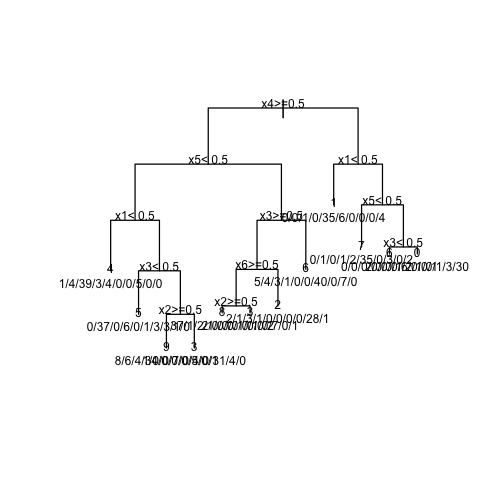

In [21]:
options(repr.plot.width=4,repr.plot.height=4)
plot(digits.rpart)
text(digits.rpart,use.n=TRUE,xpd=2,cex=0.6)

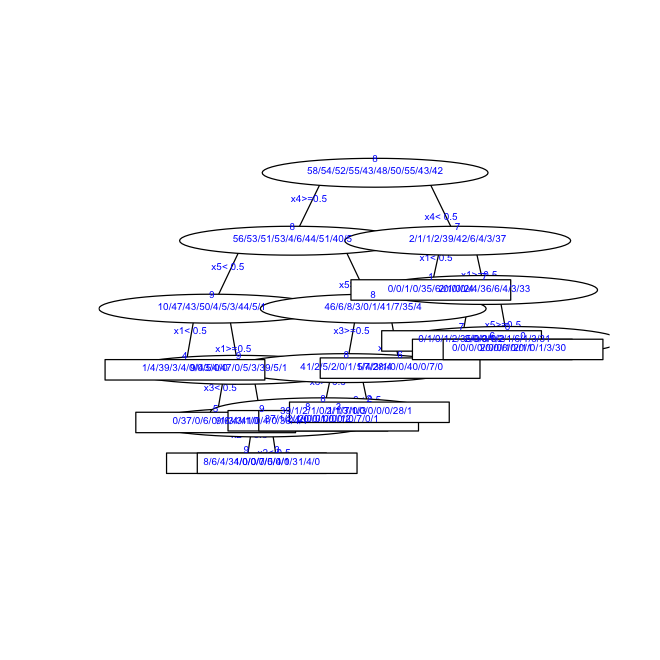

In [22]:
options(repr.plot.width=5.5,repr.plot.height=5.5)
plot(digits.rpart,branch=0.6,margin=0.2,lwd=2)
text(digits.rpart,use.n=TRUE,fancy=TRUE,fwidth=0.4,fheight=0.4,splits=TRUE,cex=0.5,all=TRUE,xpd=2,col="blue")

#### Confusion matrix

In [30]:
digits.rpart.pred<- predict(digits.rpart,digits.test, type = "class")
digits.rpart.conf<-table(True = digits.test$digit, Pred = digits.rpart.pred)
digits.rpart.conf

    Pred
True  8  5  4  9  1  7  6  3  2  0
   8  9  0  0  2  0  0  0  0  0  0
   5  1 11  1  1  0  0  0  0  0  0
   4  0  0  4  1  0  0  1  0  1  0
   9  1  1  1  5  0  0  0  1  0  0
   1  0  0  0  0  8  0  0  0  0  0
   7  0  0  0  0  2  7  0  1  0  0
   6  0  1  0  0  0  0 10  0  0  0
   3  0  1  1  2  0  0  0 11  0  0
   2  0  0  0  0  0  0  1  0  6  1
   0  0  0  0  0  1  0  0  0  0  6

#### Misclassification error estimate

In [32]:
n<-sum(digits.rpart.conf)
n1<-sum(diag(digits.rpart.conf))
P.err<-100*(n-n1)/n
round(P.err,3)

[1] 23

### Bagging

In [2]:
#install.packages("rpart",dependencies=TRUE,repos="https://cloud.r-project.org")
#install.packages("adabag",dependencies=TRUE,repos="https://cloud.r-project.org")
require(rpart)
require(adabag)

Loading required package: rpart
Loading required package: adabag
Loading required package: caret
Loading required package: lattice
Loading required package: ggplot2
Loading required package: foreach
Loading required package: doParallel
Loading required package: iterators
Loading required package: parallel


In [4]:
digits.bagging.pred<-predict.bagging(digits.bagging,newdata=digits.train)

#matriz de confusion de las predicciones
digits.bagging.conf<-digits.bagging.pred$confusion
digits.bagging.conf

#error de la prediccion de clasificacion
P.err<-1-sum(diag(digits.bagging.conf))/sum(digits.bagging.conf)
round(P.err,2)

ERROR: Error in predict.bagging(digits.bagging, newdata = digits.train): object 'digits.bagging' not found


### Random forests

In [44]:
#install.packages("rpart",dependencies=TRUE,repos="https://cloud.r-project.org")
#install.packages("randomForest",dependencies=TRUE,repos="https://cloud.r-project.org")
require(rpart)
require(randomForest)

In [63]:
digits.rf <- randomForest(digit ~ .,data=digits.train, mtry=4, importance=TRUE, proximity=TRUE)
print(digits.rf)


Call:
 randomForest(formula = digit ~ ., data = digits.train, mtry = 4,      importance = TRUE, proximity = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 28%
Confusion matrix:
   8  5  4  9  1  7  6  3  2  0 class.error
8 30  1  2  5  0  0  5  2  1  1   0.3617021
5  1 29  1  4  0  0  4  1  0  0   0.2750000
4  0  0 38  2  2  0  0  1  2  0   0.1555556
9  1  2  4 30  0  1  0  6  1  1   0.3478261
1  0  0  3  0 26  3  0  1  0  2   0.2571429
7  0  0  1  2  4 24  0  6  1  0   0.3684211
6  3  4  0  0  0  0 32  0  0  0   0.1794872
3  0  2  0  4  0  4  0 26  3  1   0.3500000
2  1  0  1  0  0  1  1  1 29  1   0.1714286
0  3  0  1  2  1  1  1  1  1 24   0.3142857


The output of `plot(iris.rf)` is a graphical representation of the _OOB_ misclasification probability estimates, with four components, the first one is the average error and the other three the individual estimates for each of the three classes.

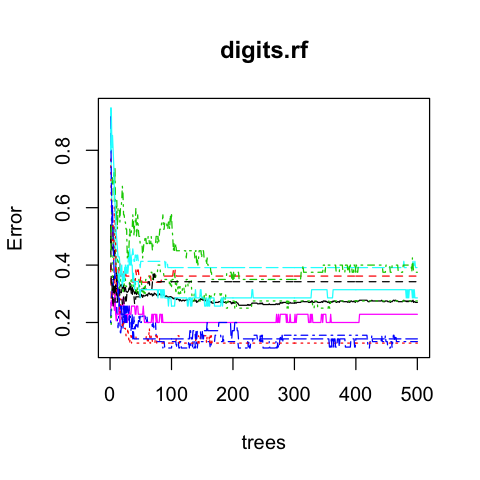

In [47]:
options(repr.plot.width=4,repr.plot.height=4)
plot(digits.rf)

The `importance()` function returns values of relative importance towards prediction of each predictor variable. In the case of a classification this importance is disaggregated for each class. 

The `varImpPlot()` gives a diagram of these values.

,8,5,4,9,1,7,6,3,2,0,MeanDecreaseAccuracy,MeanDecreaseGini
x1,3.809612,7.014741,34.59353,24.540438,62.032368,19.223731,11.410894,9.100182,-0.7519556,4.076114,65.09055,37.21406
x2,42.695174,53.484862,22.52687,27.853385,38.757919,2.028375,8.532561,50.481522,62.6957861,3.305571,105.34823,40.91084
x3,19.864482,76.489237,15.01909,24.584983,7.654223,-10.024491,87.920722,22.094136,-3.7869421,27.543703,108.25061,39.88431
x4,31.641121,17.633031,27.20435,21.479706,45.152189,35.406616,0.607329,15.797611,19.3187344,69.173599,88.22812,37.81998
x5,53.427373,38.098789,18.66865,56.375876,9.339558,39.555575,66.414669,9.132243,16.4215759,29.809989,113.06414,42.48534
x6,4.971046,2.558377,11.47332,3.249663,-2.502001,1.756012,10.253884,10.690619,104.1546199,13.314286,66.91041,28.32027
x7,8.957031,5.497271,24.76802,25.429588,11.775816,29.997701,7.210899,11.064687,16.3682318,6.585211,49.54684,27.69624


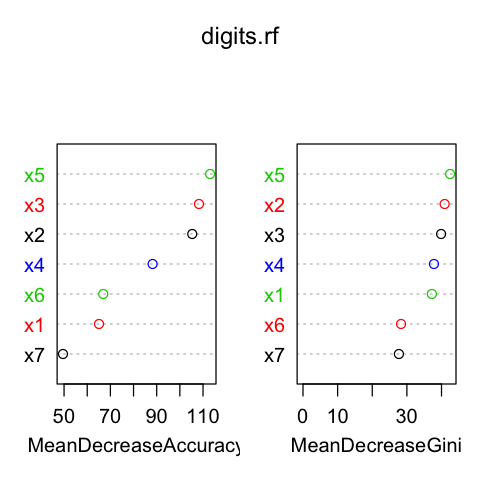

In [56]:
importance(digits.rf)
options(repr.plot.width=4,repr.plot.height=4)
varImpPlot(digits.rf,col=c(1,2,3,4))

### Naïve Bayes 